<center><h1> Accidents Corporels de la Route : T-SNE for road prediction </h1></center>
<center> - </center>
<center> En France en 2017, Projet Data Visualization IGR204 </center>
<center> `Télécom ParisTech` </center>

# Imports

In [1]:
### General
import pandas as pd
import numpy as np

### Viz
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt 

### T-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

### Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

### Autoencoder ###
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input

alt.data_transformers.enable('json')

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.21.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


DataTransformerRegistry.enable('json')

# I. The data

The data are avaialble on the French government's website.

In [2]:
lie = pd.read_csv('../Accidents/lieux_2005.csv')

#### Lieux de l'accident

- `Num_Acc` : Identifiant de l’accident identique à celui du fichier "rubrique CARACTERISTIQUES" repris dans l’accident
- `catr` : Catégorie de route :
    - 1 - Autoroute
    - 2 - Route Nationale
    - 3 - Route Départementale
    - 4 - Voie Communale
    - 5 - Hors réseau public
    - 6 - Parc de stationnement ouvert à la circulation publique
    - 9 – autre
- `voie` : Numéro de la route
    - V1 : Indice numérique du numéro de route (exemple : 2 bis, 3 ter etc.)
    - V2 : Lettre indice alphanumérique de la route
- `circ` : Régime de circulation :
    - 1 – A sens unique
    - 2 – Bidirectionnelle
    - 3 – A chaussées séparées
    - 4 – Avec voies d’affectation variable
- `nbv` : Nombre total de voies de circulation 
- `vosp` : Signale l’existence d’une voie réservée, indépendamment du fait que l’accident ait lieu ou non sur cette voie.
    - 1 – Piste cyclable
    - 2 – Banque cyclable
    - 3 – Voie réservée
- `prof` : Profil en long décrit la déclivité de la route à l'endroit de l'accident
    - 1 - Plat
    - 2 - Pente
    - 3 - Sommet de côte
    - 4- Bas de côte
- `pr` : Numéro du PR de rattachement (numéro de la borne amont)
    - pr1 : Distance en mètres au PR (par rapport à la borne amont)
- `plan`: Tracé en plan :
    - 1 – Partie rectiligne
    - 2 – En courbe à gauche
    - 3 – En courbe à droite
    - 4 – En « S »
- `lartpc` : Largeur du terre plein central (TPC) s'il existe
- `larrout` : Largeur de la chaussée affectée à la circulation des véhicules, ne sont pas compris les bandes d'arrêt d'urgence, les TPC et les places de stationnement
- `surf` : Etat de la surface
    - 1 - normale
    - 2 - mouillée
    - 3 - flaques
    - 4 - inondée
    - 5 - enneigée
    - 6 - boue
    - 7 - verglacée
    - 8 - corps gras - huile
    - 9 - autre
- `infra` : Aménagement - Infrastructure :
    - 1 – Souterrain - tunnel
    - 2 – Pont - autopont
    - 3 – Bretelle d’échangeur ou de raccordement
    - 4 - Voie ferrée
    - 5 – Carrefour aménagé
    - 6 – Zone piétonne
    - 7 – Zone de péage
- `situ` : Situation de l’accident :
    - 1 – Sur chaussée
    - 2 – Sur bande d’arrêt d’urgence
    - 3 – Sur accotement
    - 4 – Sur trottoir
    - 5 – Sur piste cyclable
- `env1` : point école : proximité d'une école 

In [3]:
lie.head()

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,200500000001,3.0,41.0,0.0,B,2,2,1.0,430.0,0,1,1,0,63,1,0,1,0
1,200500000002,2.0,41.0,0.0,NaN,0,2,0.0,0.0,1,1,1,0,100,1,0,5,0
2,200500000003,2.0,41.0,0.0,NaN,0,0,0.0,0.0,1,1,1,0,0,2,0,5,0
3,200500000004,3.0,916.0,0.0,NaN,2,2,0.0,0.0,0,1,1,0,0,1,0,1,0
4,200500000005,3.0,110.0,0.0,NaN,2,2,24.0,630.0,0,1,3,0,59,2,0,3,0


# II. Load yearly data

In [4]:
for i in range(2006,2018,1) :
    lie = pd.concat([lie, pd.read_csv('../Accidents/lieux_' + str(i) + '.csv')], axis=0)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
lie = lie[lie['larrout']>0].drop(['Num_Acc', 'voie', 'v1', 'v2', 'pr', 'pr1', 'infra', 'situ'], axis=1)

In [6]:
print(len(lie))

609636


# III. Data Exploration

In [7]:
lie.describe()

,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,surf,env1
count,609636.000000,609600.000000,608925.000000,609339.000000,609603.000000,609361.000000,608118.000000,609636.000000,609585.000000,606148.000000
mean,3.289998,1.900674,2.173245,0.129465,1.170855,1.240201,6.782879,85.035159,1.282563,40.616155
std,1.185007,0.689035,1.570028,0.553267,0.619325,0.725141,26.384469,61.970669,0.965754,48.556888
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,60.000000,1.000000,0.000000
50%,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,70.000000,1.000000,0.000000
75%,4.000000,2.000000,2.000000,0.000000,1.000000,1.000000,0.000000,100.000000,1.000000,99.000000
max,9.000000,4.000000,99.000000,3.000000,4.000000,4.000000,960.000000,999.000000,9.000000,99.000000


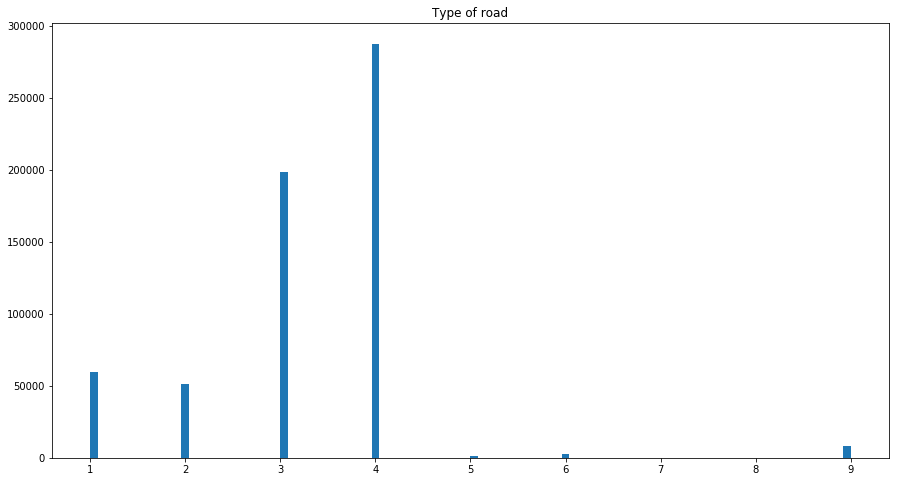

In [8]:
# Type of road
plt.figure(figsize=(15,8))
plt.hist(lie['catr'], bins=100)
plt.title('Type of road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


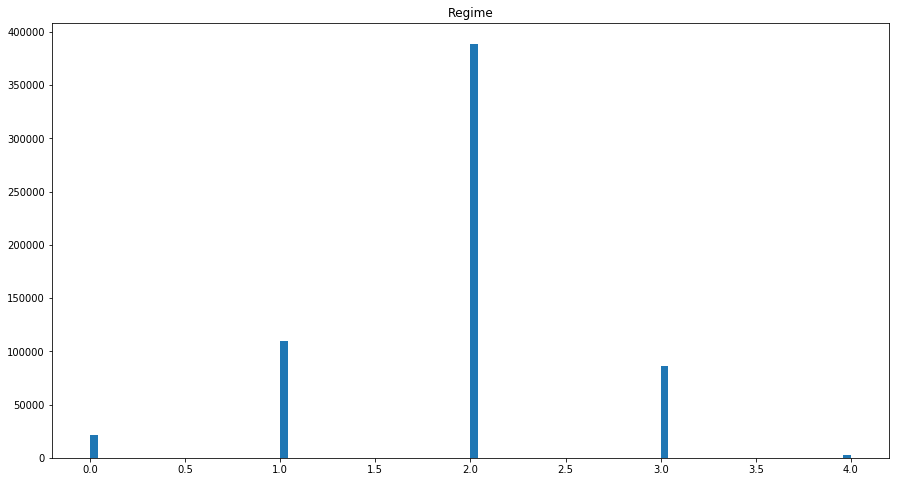

In [9]:
# Circulation Regime 
plt.figure(figsize=(15,8))
plt.hist(lie['circ'], bins=100)
plt.title('Regime')
plt.show()

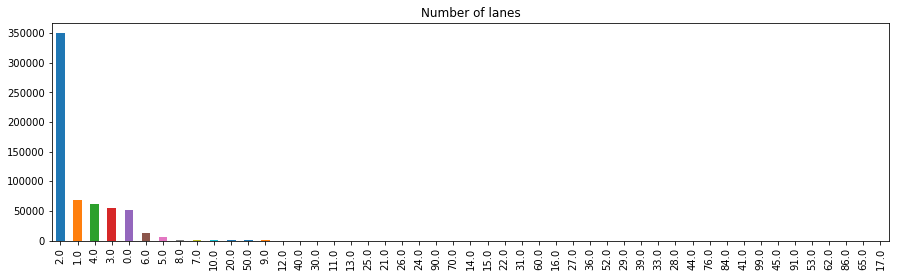

In [10]:
# Number of lanes
plt.figure(figsize=(15,4))
lie['nbv'].value_counts().plot.bar()
plt.title('Number of lanes')
plt.show()

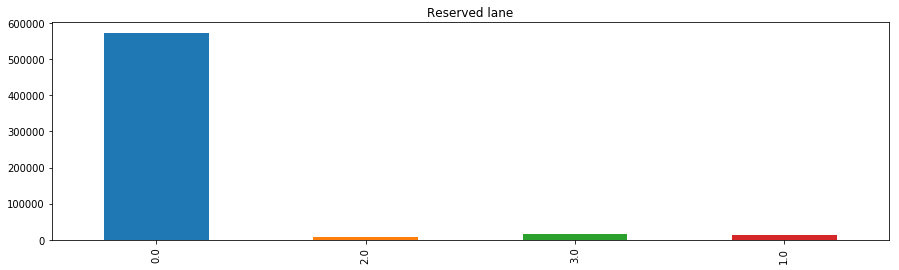

In [11]:
# Reserved lane
plt.figure(figsize=(15,4))
lie['vosp'].value_counts(sort=False).plot.bar()
plt.title('Reserved lane')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


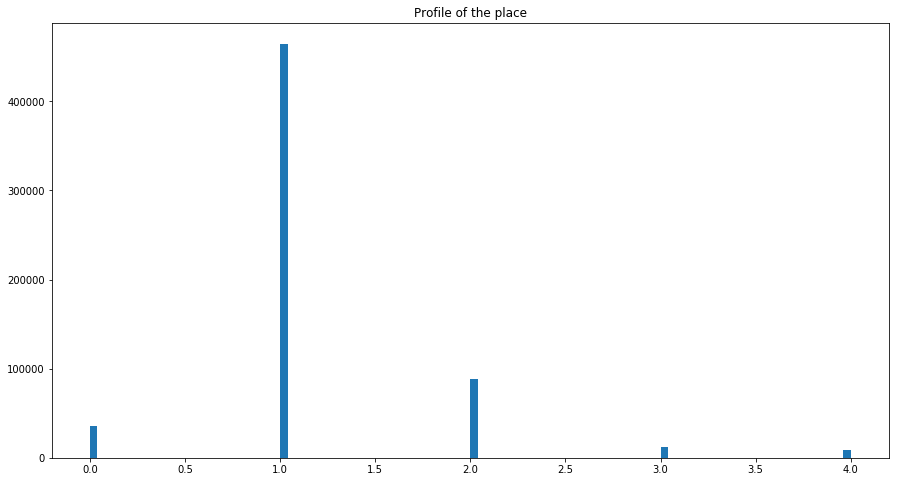

In [12]:
# Profile of the place
plt.figure(figsize=(15,8))
plt.hist(lie['prof'], bins=100)
plt.title('Profile of the place')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


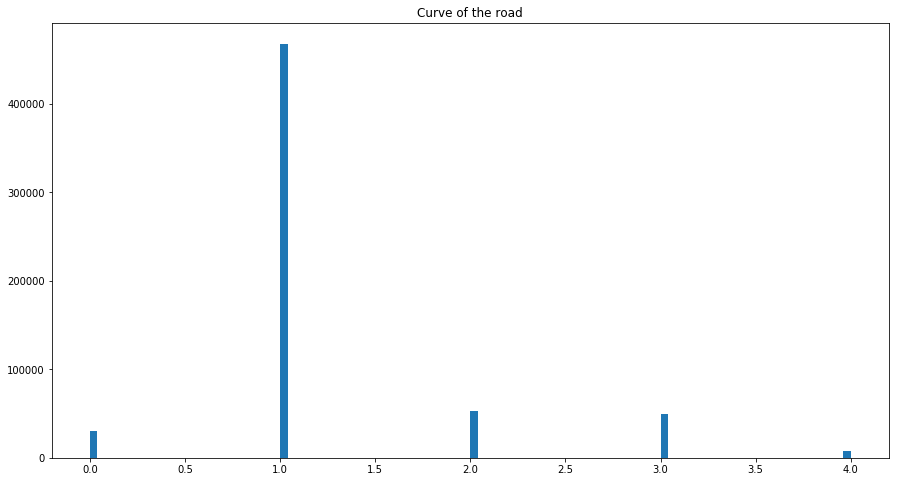

In [13]:
# Curve of the road
plt.figure(figsize=(15,8))
plt.hist(lie['plan'], bins=100)
plt.title('Curve of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


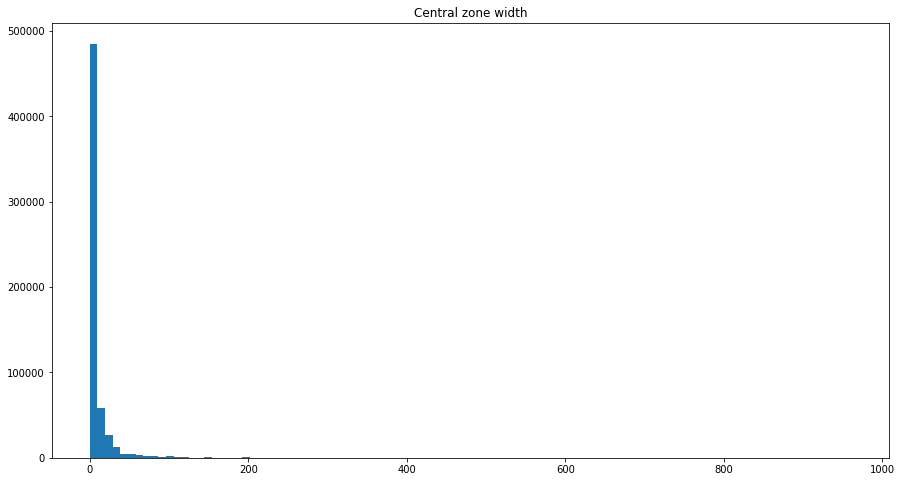

In [14]:
# Curve of the road
plt.figure(figsize=(15,8))
plt.hist(lie['lartpc'], bins=100)
plt.title('Central zone width')
plt.show()

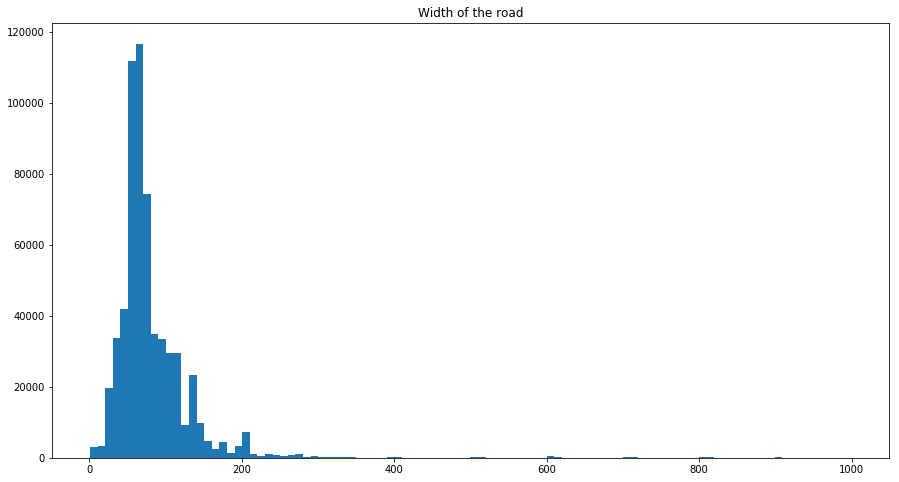

In [15]:
# Width of the road
plt.figure(figsize=(15,8))
plt.hist(lie['larrout'], bins=100)
plt.title('Width of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


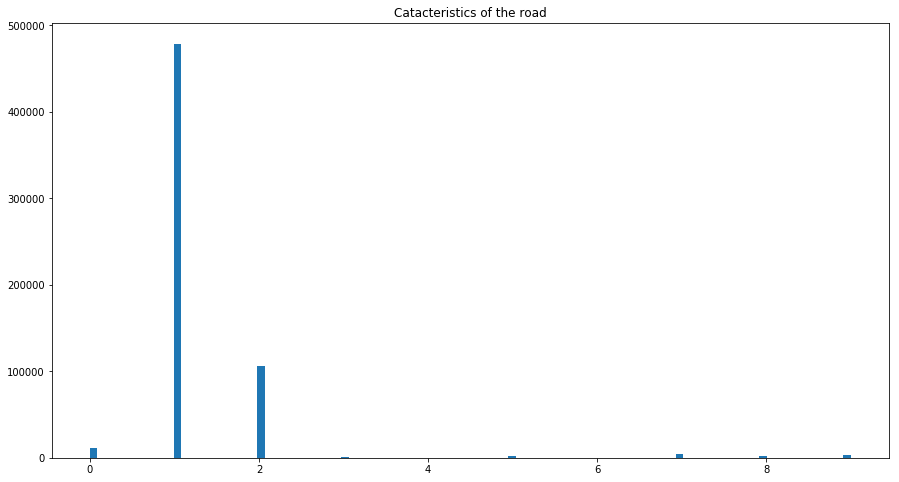

In [16]:
# Catacteristics of the road
plt.figure(figsize=(15,8))
plt.hist(lie['surf'], bins=100)
plt.title('Catacteristics of the road')
plt.show()

/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


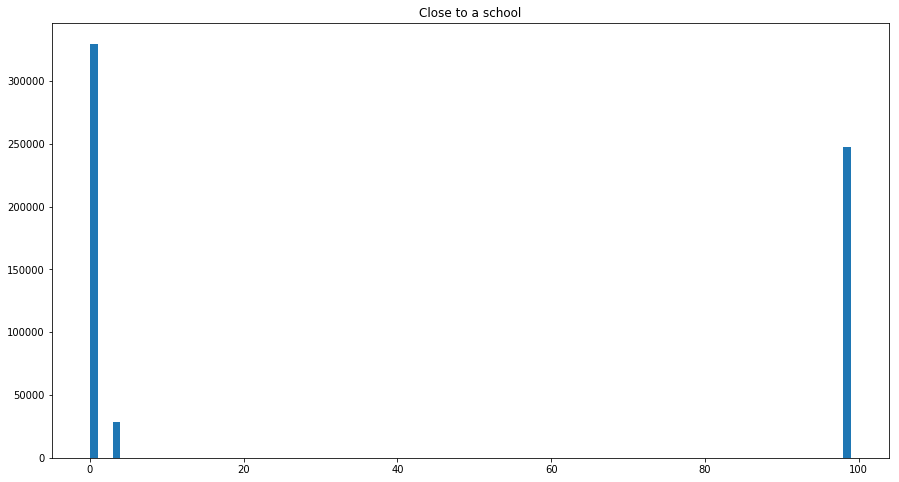

In [17]:
# Close to a school
plt.figure(figsize=(15,8))
plt.hist(lie['env1'], bins=100)
plt.title('Close to a school')
plt.show()

# IV. Data Cleaning

In [18]:
lie = lie[lie['catr'] != 9]
lie = lie[lie['circ'] != 4]
lie = lie[lie['nbv'] <= 8]

def cyclable(num) :
    if num == 1 or num == 2 :
        return 1
    else :
        return 0
    
lie['vosp'] = lie['vosp'].apply(lambda x : cyclable(x))

lie = lie[lie['plan'] != 0]
lie = lie[lie['prof'] != 0]
lie = lie[lie['lartpc'] <= 200]
lie = lie[lie['larrout'] <= 200]
lie = lie[lie['surf'] < 8]
lie = lie[lie['surf'] != 0]

def school(num) :
    if school == 0 :
        return 0
    else :
        return 1

lie['env1'] = lie['env1'].apply(lambda x : cyclable(x))

In [19]:
lie = lie[lie['plan'] != 0]

In [20]:
lie = lie.dropna()
print(len(lie))

511008


In [21]:
lie['tot'] = 1
lie = lie.groupby(['catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'surf', 'env1'])['tot'].agg(np.sum).reset_index()
def val(num) :
    if num == 1 :
        return 1 
    elif num  < 3 :
        return 2
    elif num < 10 :
        return 3
    elif num < 50 :
        return 4
    else : return 5
    
lie['tot_val'] = lie['tot'].apply(lambda x: val(x))

In [22]:
lie.describe()

,catr,circ,nbv,vosp,prof,plan,lartpc,larrout,surf,env1,tot,tot_val
count,88653.000000,88653.000000,88653.000000,88653.000000,88653.000000,88653.000000,88653.000000,88653.000000,88653.000000,88653.0,88653.000000,88653.000000
mean,2.990999,1.967119,2.304863,0.085671,1.466470,1.513891,18.760832,88.306904,1.472234,0.0,5.764137,1.585767
std,1.099743,0.873806,1.445600,0.279879,0.791226,0.842583,30.753189,41.835204,1.063344,0.0,82.001021,0.982321
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.0,1.000000,1.000000
25%,2.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0.000000,60.000000,1.000000,0.0,1.000000,1.000000
50%,3.000000,2.000000,2.000000,0.000000,1.000000,1.000000,8.000000,80.000000,1.000000,0.0,1.000000,1.000000
75%,4.000000,3.000000,3.000000,0.000000,2.000000,2.000000,25.000000,115.000000,2.000000,0.0,2.000000,2.000000
max,6.000000,3.000000,8.000000,1.000000,4.000000,4.000000,200.000000,200.000000,7.000000,0.0,15564.000000,5.000000


# V. Build the model

In [112]:
X, y = lie.drop(['tot', 'tot_val'], axis=1), lie['tot_val']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [113]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_score(y_pred, y_test)

0.6629669734704927

In [114]:
rf = RandomForestClassifier(n_estimators=100, max_depth=50)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [115]:
import pickle

In [116]:
#filename = 'rf_model.sav'
#pickle.dump(rf, open(filename, 'wb'))

In [118]:
catr = 4.0
circ = 2.0
nbv = 2.0
vosp = 0
prof = 1
plan = 1
lartpc = 0
larrout = 3
surf = 1
env1 = 0

In [119]:
rf.predict([(catr, circ, nbv, vosp, prof, plan, lartpc, larrout, surf, env1)])

array([2])

In [120]:
lie.to_csv('lie_final.csv')

# VI. 2D-Plot

To display the final information, we'll need these dictionnaries :

In [24]:
catr_dict = {1 : 'Autoroute',
             2 : 'Route Nationale',
             3 : 'Route Départementale',
             4 : 'Voie Communale',
             5 : 'Hors réseau public',
             6 : 'Parc de stationnement',
             9 : 'Other'
            }

circ_dict = {0 : 'A sens unique',
             1 : 'Bidirectionnelle',
             2 : 'A chaussées séparées',
             3 : 'Avec voies d’affectation variable'
            }
             
env1_dict = {1 : 'Oui',
             0 : 'Non'
            }

vosp_dict = {1 : 'Oui',
             0 : 'Non'
            }

prof_dict = {1 : 'Plat',
             2 : 'Pente',
             3 : 'Sommet de côte',
             4 : 'Bas de côte'
            }

plan_dict = {1 : 'Partie rectiligne',
             2 : 'En courbe à gauche',
             3 : 'En courbe à droite',
             4 : 'En S'
            }

surf_dict = {1 : 'Normale',
             2 : 'Mouillée',
             3 : 'Flaques',
             4 : 'Inondée',
             5 : 'Enneigée',
             6 : 'Boue',
             7 : 'Verglacée',         
            }

### 1. T-SNE dimension reduction on similar roads

In [38]:
# Wrap it up in a function
def retun_tsne(var, const, X, rf, factor) :
    #try :
    val_lartpc_min = var['lartpc']*1/factor
    val_lartpc_max = var['lartpc']*factor

    val_larrout_min = var['larrout']*1/factor
    val_larrout_max = var['larrout']*factor

    X = X[ (X['lartpc'].astype(float) > val_lartpc_min) 
          & (X['lartpc'].astype(float) < val_lartpc_max) 
          & (X['larrout'].astype(float) > val_larrout_min) 
          & (X['larrout'].astype(float) < val_larrout_max) 
          & (X['catr'] == const['catr'])
          & (X['circ'] == const['circ'])
          & (X['nbv'] == const['nbv'])
          & (X['env1'] == const['env1'])
         ]

    X_you = X[ (X['lartpc'] == var['lartpc']) 
          & (X['larrout'] == var['larrout']) 
          & (X['catr'] == const['catr'])
          & (X['circ'] == const['circ'])
          & (X['nbv'] == const['nbv'])
          & (X['vosp'] == const['vosp'])
          & (X['prof'] == const['prof'])
          & (X['plan'] == const['plan'])
          & (X['surf'] == const['surf'])
          & (X['env1'] == const['env1'])
        ]

    tsne = TSNE(n_components=2).fit_transform(pd.concat([X, X_you], axis=0))

    X['tsne-one'] = tsne[:,0][:len(X)]
    X['tsne-two'] = tsne[:,1][:len(X)]

    X_you['tsne-one'] = tsne[:,0][len(X):]
    X_you['tsne-two'] = tsne[:,1][len(X):]

    X['env1'] = X['env1'].apply(lambda x: env1_dict[x])
    X_you['env1'] = X_you['env1'].apply(lambda x: env1_dict[x])

    X['catr'] = X['catr'].apply(lambda x: catr_dict[x])
    X_you['catr'] = X_you['catr'].apply(lambda x: catr_dict[x])

    X['circ'] = X['circ'].apply(lambda x: circ_dict[x])
    X_you['circ'] = X_you['circ'].apply(lambda x: circ_dict[x])

    X['vosp'] = X['vosp'].apply(lambda x: vosp_dict[x])
    X_you['vosp'] = X_you['vosp'].apply(lambda x: vosp_dict[x])

    X['prof'] = X['prof'].apply(lambda x: prof_dict[x])
    X_you['prof'] = X_you['prof'].apply(lambda x: prof_dict[x])

    X['surf'] = X['surf'].apply(lambda x: surf_dict[x])
    X_you['surf'] = X_you['surf'].apply(lambda x: surf_dict[x])

    X['plan'] = X['plan'].apply(lambda x: plan_dict[x])
    X_you['plan'] = X_you['plan'].apply(lambda x: plan_dict[x])

    def plot_tsne(df, df_you) :
        tsne = alt.Chart(df[:4000]).mark_point().encode(
            x='tsne-one',
            y='tsne-two', 
            color=alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0])),
            tooltip=[
                alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                alt.Tooltip('larrout:Q', title="Largeur Route"),
                alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                alt.Tooltip('env1:N', title="Ecole Proximite"),
                alt.Tooltip('catr:N', title="Categorie Route"),
                alt.Tooltip('circ:N', title="Regime Circulation"),
                alt.Tooltip('nbv:Q', title="Nombre Voies"),
                alt.Tooltip('vosp:N', title="Piste Cyclable"),
                alt.Tooltip('prof:N', title="Profile"),
                alt.Tooltip('surf:N', title="Surface")
                #alt.Tooltip('plan:N', title="Virage")
            ]
        ).properties(
            width=750,
            height=500
        )

        you = alt.Chart(df_you).mark_point(
            color='black',
            size=190,
        ).encode(
            x='tsne-one',
            y='tsne-two', 
            tooltip=[
                alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                alt.Tooltip('larrout:Q', title="Largeur Route"),
                alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                alt.Tooltip('env1:N', title="Ecole Proximite"),
                alt.Tooltip('catr:N', title="Categorie Route"),
                alt.Tooltip('circ:N', title="Regime Circulation"),
                alt.Tooltip('nbv:Q', title="Nombre Voies"),
                alt.Tooltip('vosp:N', title="Piste Cyclable"),
                alt.Tooltip('prof:N', title="Profile"),
                alt.Tooltip('surf:N', title="Surface")
                #alt.Tooltip('plan:N', title="Virage")
            ]
        )

        return tsne + you

    df = X[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'catr', 'circ', 'nbv', 'env1', 'vosp', 'prof', 'surf']]
    df_you = X_you[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'catr', 'circ', 'nbv', 'env1']]

    # Prediction
    to_pred = [(const['catr'], const['circ'], const['nbv'], const['vosp'], const['prof'], const['plan'], var['lartpc'], var['larrout'], const['surf'], const['env1'])]
    predicted_acc = rf.predict(to_pred)[0]

    print("The road predicted accidentology is : " + str(predicted_acc))

    return plot_tsne(df, df_you)

    #except :
        #return ("Not enough data points to compare to.")
        
var = {}
var['lartpc'] = 1.0
var['larrout'] = 3.0

const = {}
const['catr'] = 4.0
const['circ'] = 2.0
const['nbv'] = 2.0
const['vosp'] = 0.0
const['prof'] = 1.0
const['plan'] = 1.0
const['surf'] = 1.0
const['env1'] = 0.0

X_2 = X.copy()
X_2['tot_val'] = lie['tot_val']
X_2.to_csv('road_data.csv')

retun_tsne(var, const, X_2, rf, 3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

The road predicted accidentology is : 5


<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


### 2. T-SNE dimension reduction on roads of the same category

In [ ]:
var = {}
var['lartpc'] = 1.0
var['larrout'] = 3.0

const = {}
const['catr'] = 4.0
const['circ'] = 2.0
const['nbv'] = 2.0
const['vosp'] = 0.0
const['prof'] = 1.0
const['plan'] = 1.0
const['surf'] = 1.0
const['env1'] = 0.0

In [40]:
def retun_tsne(catr, X, name) :
    
    #X = X[X['catr'] == catr]
    
    if len(X) >= 5000 :
        X = X.sample(4999)
    
    X = X.drop(['surf'], axis=1)
    print(X.head())
    #X_you = X[ (X['lartpc'] == var['lartpc']) 
          #& (X['larrout'] == var['larrout']) 
          #& (X['catr'] == const['catr'])
          #& (X['circ'] == const['circ'])
          #& (X['nbv'] == const['nbv'])
          #& (X['vosp'] == const['vosp'])
          #& (X['prof'] == const['prof'])
          #& (X['plan'] == const['plan'])
          #& (X['surf'] == const['surf'])
          #& (X['env1'] == const['env1'])
        #]

    tsne = TSNE(n_components=2).fit_transform(X) #pd.concat([X, X_you], axis=0))
 
    X['tsne-one'] = tsne[:,0] #[:len(X)]
    X['tsne-two'] = tsne[:,1] #[:len(X)]

    #X_you['tsne-one'] = tsne[:,0][len(X):]
    #X_you['tsne-two'] = tsne[:,1][len(X):]

    X['env1'] = X['env1'].apply(lambda x: env1_dict[x])
    #X_you['env1'] = X_you['env1'].apply(lambda x: env1_dict[x])

    X['catr'] = X['catr'].apply(lambda x: catr_dict[x])
    #X_you['catr'] = X_you['catr'].apply(lambda x: catr_dict[x])

    X['circ'] = X['circ'].apply(lambda x: circ_dict[x])
    #X_you['circ'] = X_you['circ'].apply(lambda x: circ_dict[x])

    X['vosp'] = X['vosp'].apply(lambda x: vosp_dict[x])
    #X_you['vosp'] = X_you['vosp'].apply(lambda x: vosp_dict[x])

    X['prof'] = X['prof'].apply(lambda x: prof_dict[x])
    #X_you['prof'] = X_you['prof'].apply(lambda x: prof_dict[x])

    #X['surf'] = X['surf'].apply(lambda x: surf_dict[x])
   # X_you['surf'] = X_you['surf'].apply(lambda x: surf_dict[x])

    X['plan'] = X['plan'].apply(lambda x: plan_dict[x])
    #X_you['plan'] = X_you['plan'].apply(lambda x: plan_dict[x])

    def plot_tsne(df) :

        scales = alt.selection_interval(bind='scales')

        tsne = alt.Chart(df).mark_point(size=190).encode(
            x='tsne-one',
            y='tsne-two', 
            color=alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0])),
            tooltip=[
                alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                alt.Tooltip('larrout:Q', title="Largeur Route"),
                alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                alt.Tooltip('env1:N', title="Ecole Proximite"),
                alt.Tooltip('circ:N', title="Regime Circulation"),
                alt.Tooltip('nbv:Q', title="Nombre Voies"),
                alt.Tooltip('vosp:N', title="Piste Cyclable"),
                alt.Tooltip('prof:N', title="Profile"),
                alt.Tooltip('catr:N', title="Categorie Route")
                #alt.Tooltip('surf:N', title="Surface")
            ]
        ).properties(
            width=1000,
            height=500
        ).add_selection(
            scales
        )
            
        #you = alt.Chart(df_you).mark_circle(
            #color='blue',
            #size=300,
        #).encode(
            #x='tsne-one',
           # y='tsne-two', 
           # tooltip=[
            #    alt.Tooltip('tot_val:Q', title="Accidentologie"), 
            #    alt.Tooltip('larrout:Q', title="Largeur Route"),
            #    alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
            #    alt.Tooltip('env1:N', title="Ecole Proximite"),
            #    alt.Tooltip('catr:N', title="Categorie Route"),
            #    alt.Tooltip('circ:N', title="Regime Circulation"),
            #    alt.Tooltip('nbv:Q', title="Nombre Voies"),
            #    alt.Tooltip('vosp:N', title="Piste Cyclable"),
            #    alt.Tooltip('prof:N', title="Profile"),
            #    alt.Tooltip('surf:N', title="Surface")
            #]
        #)

        #chart = tsne #( + you)
        return tsne.save(name)
        
        #return chart

    df = X[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'circ', 'catr', 'nbv', 'env1', 'vosp', 'prof']]
    #df_you = X_you[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'catr', 'circ', 'nbv', 'env1',  'vosp', 'prof', 'surf']]

    # Prediction
    #to_pred = [(const['catr'], const['circ'], const['nbv'], const['vosp'], const['prof'], const['plan'], var['lartpc'], var['larrout'], const['surf'], const['env1'])]
    #predicted_acc = rf.predict(to_pred)[0]

    #print("The road predicted accidentology is : " + str(predicted_acc))

    return plot_tsne(df)

### 2.bis. Interactive graph (selection of similar roads, zoom) T-SNE

In [122]:
def retun_tsne(X_2, name, catr=1, all_roads=True) :
    
    if all_roads :
        if len(X_2) >= 5000 :
            X_2 = X_2.sample(10000)

        X = X_2.drop(['surf', 'tot_val'], axis=1)

        tsne = TSNE(n_components=2).fit_transform(X)

        X_2['tsne-one'] = tsne[:,0]
        X_2['tsne-two'] = tsne[:,1]
        X_2['env1'] = X_2['env1'].apply(lambda x: env1_dict[x])
        X_2['catr'] = X_2['catr'].apply(lambda x: catr_dict[x])
        X_2['circ'] = X_2['circ'].apply(lambda x: circ_dict[x])
        X_2['vosp'] = X_2['vosp'].apply(lambda x: vosp_dict[x])
        X_2['prof'] = X_2['prof'].apply(lambda x: prof_dict[x])
        X_2['plan'] = X_2['plan'].apply(lambda x: plan_dict[x])

        def plot_tsne(df) :

                scales = alt.selection_interval(bind='scales')

                selection = alt.selection_multi(fields=['tot_val'])

                color = alt.condition(selection,
                          alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0]), legend=None),
                          alt.value('lightgray'))

                tsne = alt.Chart(df).mark_point(size=30).encode(
                    x='tsne-one',
                    y='tsne-two', 
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                        alt.Tooltip('larrout:Q', title="Largeur Route"),
                        alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                        alt.Tooltip('env1:N', title="Ecole Proximite"),
                        alt.Tooltip('circ:N', title="Regime Circulation"),
                        alt.Tooltip('nbv:Q', title="Nombre Voies"),
                        alt.Tooltip('vosp:N', title="Piste Cyclable"),
                        alt.Tooltip('prof:N', title="Profile"),
                        alt.Tooltip('catr:N', title="Categorie Route")
                    ]
                ).properties(
                    width=1000,
                    height=650
                ).add_selection(
                    scales
                )

                legend = alt.Chart(df).mark_point().encode(
                    y=alt.Y('tot_val:Q', axis=alt.Axis(orient='right')),
                    color=color
                ).add_selection(
                    selection
                )

                chart = tsne | legend

                return chart.save(name)

        df = X_2[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'circ', 'catr', 'nbv', 'env1', 'vosp', 'prof']]

        return plot_tsne(df)
    
    else :
        
        X_2 = X_2[X_2['catr'] == catr]
        
        if len(X_2) >= 5000 :
            X_2 = X_2.sample(10000)

        X = X_2.drop(['surf', 'catr', 'tot_val'], axis=1)

        tsne = TSNE(n_components=2).fit_transform(X)

        X_2['tsne-one'] = tsne[:,0]
        X_2['tsne-two'] = tsne[:,1]
        X_2['env1'] = X_2['env1'].apply(lambda x: env1_dict[x])
        #X_2['catr'] = X_2['catr'].apply(lambda x: catr_dict[x])
        X_2['circ'] = X_2['circ'].apply(lambda x: circ_dict[x])
        X_2['vosp'] = X_2['vosp'].apply(lambda x: vosp_dict[x])
        X_2['prof'] = X_2['prof'].apply(lambda x: prof_dict[x])
        X_2['plan'] = X_2['plan'].apply(lambda x: plan_dict[x])

        def plot_tsne(df) :

                scales = alt.selection_interval(bind='scales')

                selection = alt.selection_multi(fields=['tot_val'])

                color = alt.condition(selection,
                          alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0]), legend=None),
                          alt.value('lightgray'))

                tsne = alt.Chart(df).mark_point(size=30).encode(
                    x='tsne-one',
                    y='tsne-two', 
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                        alt.Tooltip('larrout:Q', title="Largeur Route"),
                        alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                        alt.Tooltip('env1:N', title="Ecole Proximite"),
                        alt.Tooltip('circ:N', title="Regime Circulation"),
                        alt.Tooltip('nbv:Q', title="Nombre Voies"),
                        alt.Tooltip('vosp:N', title="Piste Cyclable"),
                        alt.Tooltip('prof:N', title="Profile")
                        #alt.Tooltip('catr:N', title="Categorie Route")
                    ]
                ).properties(
                    width=1000,
                    height=650
                ).add_selection(
                    scales
                )

                legend = alt.Chart(df).mark_point().encode(
                    y=alt.Y('tot_val:Q', axis=alt.Axis(orient='right')),
                    color=color
                ).add_selection(
                    selection
                )

                chart = tsne | legend

                return chart.save(name)

        df = X_2[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'circ', 'nbv', 'env1', 'vosp', 'prof']]

        return plot_tsne(df)

In [81]:
retun_tsne(lie, 'tsne_all.html', 1, True)

In [82]:
retun_tsne(lie, 'tsne_com.html', 4, False)

In [83]:
retun_tsne(lie, 'tsne_dep.html', 3, False)

In [84]:
retun_tsne(lie, 'tsne_nat.html', 2, False)

In [85]:
retun_tsne(lie, 'tsne_aut.html', 1, False)

### 2.c. T-SNE dimension reduction + histogram

In [36]:
def retun_tsne(X_2, name, catr=1, all_roads=True) :
    
    if all_roads :
        if len(X_2) >= 5000 :
            X_2 = X_2.sample(10000)

        X = X_2.drop(['surf', 'tot_val'], axis=1)

        tsne = TSNE(n_components=2).fit_transform(X)

        X_2['tsne-one'] = tsne[:,0]
        X_2['tsne-two'] = tsne[:,1]
        X_2['env1'] = X_2['env1'].apply(lambda x: env1_dict[x])
        X_2['catr'] = X_2['catr'].apply(lambda x: catr_dict[x])
        X_2['circ'] = X_2['circ'].apply(lambda x: circ_dict[x])
        X_2['vosp'] = X_2['vosp'].apply(lambda x: vosp_dict[x])
        X_2['prof'] = X_2['prof'].apply(lambda x: prof_dict[x])
        X_2['plan'] = X_2['plan'].apply(lambda x: plan_dict[x])

        def plot_tsne(df) :

                scales = alt.selection_interval(bind='scales')

                selection = alt.selection_multi(fields=['tot_val'])

                color = alt.condition(selection,
                          alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0]), legend=None),
                          alt.value('lightgray'))

                brush = alt.selection(type='interval')
                
                tsne = alt.Chart(df).mark_point(size=30).encode(
                    x='tsne-one',
                    y='tsne-two', 
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                        alt.Tooltip('larrout:Q', title="Largeur Route"),
                        alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                        alt.Tooltip('env1:N', title="Ecole Proximite"),
                        alt.Tooltip('circ:N', title="Regime Circulation"),
                        alt.Tooltip('nbv:Q', title="Nombre Voies"),
                        alt.Tooltip('vosp:N', title="Piste Cyclable"),
                        alt.Tooltip('prof:N', title="Profile"),
                        alt.Tooltip('catr:N', title="Categorie Route")
                    ]
                ).properties(
                    width=700,
                    height=400
                ).add_selection(
                    brush
                )

                legend = alt.Chart(df).mark_point().encode(
                    y=alt.Y('tot_val:Q', axis=alt.Axis(orient='right')),
                    color=color
                ).add_selection(
                    selection
                ).properties(
                    width=40,
                    height=400
                )
                
                
                bars = alt.Chart(df).mark_bar().encode(
                    alt.X("larrout:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Largeur Route')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('larrout:Q', title="Largeur Route")]
                ).transform_filter(
                    brush
                ).properties(
                    width=350,
                    height=200
                )
                
                bars_2 = alt.Chart(df).mark_bar().encode(
                    alt.X("lartpc:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Largeur TPC')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('lartpc:Q', title="Largeur TPC")]
                ).transform_filter(
                    brush
                ).properties(
                    width=350,
                    height=200
                )
                
                bars_3 = alt.Chart(df).mark_bar().encode(
                    alt.X("catr:N", axis=alt.Axis(title='Road Type')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('catr:N', title="Road Type")]
                ).transform_filter(
                    brush
                ).properties(
                    width=350,
                    height=200
                )
                
                bars_4 = alt.Chart(df).mark_bar().encode(
                    alt.X("nbv:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Nombre Voies')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('nbv:Q', title="Nombre de voies")]
                ).transform_filter(
                    brush
                ).properties(
                    width=265,
                    height=175
                )
                
                
                acc = alt.Chart(df).mark_bar().encode(
                    alt.X("tot_val:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Accidentology')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentology")]
                ).transform_filter(
                    brush
                ).properties(
                    width=265,
                    height=175
                )

                chart = (legend | tsne | ( acc & bars_4) ) & ( bars | bars_2 | bars_3 )

                return chart.save(name)

        df = X_2[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'circ', 'catr', 'nbv', 'env1', 'vosp', 'prof']]

        return plot_tsne(df)
    
    else :
        
        X_2 = X_2[X_2['catr'] == catr]
        
        if len(X_2) >= 5000 :
            X_2 = X_2.sample(10000)

        X = X_2.drop(['surf', 'catr', 'tot_val'], axis=1)

        tsne = TSNE(n_components=2).fit_transform(X)

        X_2['tsne-one'] = tsne[:,0]
        X_2['tsne-two'] = tsne[:,1]
        X_2['env1'] = X_2['env1'].apply(lambda x: env1_dict[x])
        #X_2['catr'] = X_2['catr'].apply(lambda x: catr_dict[x])
        X_2['circ'] = X_2['circ'].apply(lambda x: circ_dict[x])
        X_2['vosp'] = X_2['vosp'].apply(lambda x: vosp_dict[x])
        X_2['prof'] = X_2['prof'].apply(lambda x: prof_dict[x])
        X_2['plan'] = X_2['plan'].apply(lambda x: plan_dict[x])

        def plot_tsne(df) :

                scales = alt.selection_interval(bind='scales')

                selection = alt.selection_multi(fields=['tot_val'])

                color = alt.condition(selection,
                          alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0]), legend=None),
                          alt.value('lightgray'))

                brush = alt.selection(type='interval')
                
                tsne = alt.Chart(df).mark_point(size=30).encode(
                    x='tsne-one',
                    y='tsne-two', 
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentologie"), 
                        alt.Tooltip('larrout:Q', title="Largeur Route"),
                        alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
                        alt.Tooltip('env1:N', title="Ecole Proximite"),
                        alt.Tooltip('circ:N', title="Regime Circulation"),
                        alt.Tooltip('nbv:Q', title="Nombre Voies"),
                        alt.Tooltip('vosp:N', title="Piste Cyclable"),
                        alt.Tooltip('prof:N', title="Profile"),
                        #alt.Tooltip('catr:N', title="Categorie Route")
                    ]
                ).properties(
                    width=700,
                    height=400
                ).add_selection(
                    brush
                )
                
                #.add_selection(
                    #scales
                #)

                legend = alt.Chart(df).mark_point().encode(
                    y=alt.Y('tot_val:Q', axis=alt.Axis(orient='right')),
                    color=color
                ).add_selection(
                    selection
                ).properties(
                    width=40,
                    height=400
                )
                
                
                bars = alt.Chart(df).mark_bar().encode(
                    alt.X("larrout:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Largeur Route')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('larrout:Q', title="Largeur Route")]
                ).transform_filter(
                    brush
                ).properties(
                    width=450,
                    height=200
                )
                
                bars_2 = alt.Chart(df).mark_bar().encode(
                    alt.X("lartpc:Q", bin=alt.Bin(maxbins=50), axis=alt.Axis(title='Largeur TPC')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('lartpc:Q', title="Largeur TPC")]
                ).transform_filter(
                    brush
                ).properties(
                    width=450,
                    height=200
                )
                
                bars_3 = alt.Chart(df).mark_bar().encode(
                    alt.X("vosp:N", axis=alt.Axis(title='Piste Cyclable')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('vosp:N', title="Piste Cyclable")]
                ).transform_filter(
                    brush
                ).properties(
                    width=150,
                    height=200
                )
                
                bars_4 = alt.Chart(df).mark_bar().encode(
                    alt.X("nbv:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Nombre Voies')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('nbv:Q', title="Nombre de voies")]
                ).transform_filter(
                    brush
                ).properties(
                    width=265,
                    height=175
                )
                
                
                acc = alt.Chart(df).mark_bar().encode(
                    alt.X("tot_val:Q", bin=alt.Bin(maxbins=10), axis=alt.Axis(title='Accidentology')),
                    y='count()',
                    color=color,
                    tooltip=[
                        alt.Tooltip('tot_val:Q', title="Accidentology")]
                ).transform_filter(
                    brush
                ).properties(
                    width=265,
                    height=175
                )

                chart = (legend | tsne | ( acc & bars_4) ) & ( bars | bars_2 | bars_3 )

                return chart.save(name)
        df = X_2[['tsne-one', 'tsne-two', 'tot_val', 'lartpc', 'larrout', 'circ', 'nbv', 'env1', 'vosp', 'prof']]

        return plot_tsne(df)

In [37]:
retun_tsne(lie, 'tsne_all_5.html', 1, True)

In [38]:
retun_tsne(lie, 'tsne_aut_3.html', 1, False)

In [39]:
retun_tsne(lie, 'tsne_nat_3.html', 2, False)

In [40]:
retun_tsne(lie, 'tsne_dep_3.html', 3, False)

In [41]:
retun_tsne(lie, 'tsne_com_3.html', 4, False)

### 3. PCA dimension reduction

In [46]:
#X = X.drop(['tot_val'], axis=1)

In [83]:
def process_df(catr, X) :
    pca_2 = PCA(n_components=2)
    
    X = X[X['catr'] == catr]
    if len(X) >= 5000 :
        X = X.sample(4999)

    pca = pca_2.fit_transform(X)
    
    X['pca-one'] = pca[:,0][:len(X)]
    X['pca-two'] = pca[:,1][:len(X)]

    X['tot_val'] = y
    
    df_2 = X[['pca-one', 'pca-two', 'tot_val', 'lartpc', 'larrout', 'catr', 'circ', 'nbv', 'env1', 'vosp', 'prof', 'surf']]
    
    X['env1'] = X['env1'].apply(lambda x: env1_dict[x])
    X['catr'] = X['catr'].apply(lambda x: catr_dict[x])
    X['circ'] = X['circ'].apply(lambda x: circ_dict[x])
    X['vosp'] = X['vosp'].apply(lambda x: vosp_dict[x])
    X['prof'] = X['prof'].apply(lambda x: prof_dict[x])
    X['surf'] = X['surf'].apply(lambda x: surf_dict[x])
    X['plan'] = X['plan'].apply(lambda x: plan_dict[x])

    
    df = X[['pca-one', 'pca-two', 'tot_val', 'lartpc', 'larrout', 'catr', 'circ', 'nbv', 'env1', 'vosp', 'prof', 'surf']]
    
    return df, df_2

X_pca, X_pca_2 = process_df(2, X)


In [85]:
def plot_pca(df) :

    
    pca = alt.Chart(df.sample(4999)).mark_point(size=190).encode(
        x='pca-one',
        y='pca-two', 
        color=alt.Color('tot_val:Q', scale=alt.Scale(scheme='redyellowgreen', domain=[5,0])),
        tooltip=[
            alt.Tooltip('tot_val:Q', title="Accidentologie"), 
            alt.Tooltip('larrout:Q', title="Largeur Route"),
            alt.Tooltip('lartpc:Q', title="Largeur Terre-Plein"),
            alt.Tooltip('env1:N', title="Ecole Proximite"),
            alt.Tooltip('catr:N', title="Categorie Route"),
            alt.Tooltip('circ:N', title="Regime Circulation"),
            alt.Tooltip('nbv:Q', title="Nombre Voies"),
            alt.Tooltip('vosp:N', title="Piste Cyclable"),
            alt.Tooltip('prof:N', title="Profile"),
            alt.Tooltip('surf:N', title="Surface")
        ]
    ).properties(
        width=1500,
        height=1000
    )

    pca.save('pca.html')
        
    return pca

In [87]:
plot_pca(X_pca)

NameError: name 'plot_pca' is not defined

### 4. Auto-Encoder dimension reduction

In [100]:
input_data = Input(shape=(10,))
encoded = Dense(8, activation='relu')(input_data)
encoded = Dense(4, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

decoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(decoded)
decoded = Dense(10, activation='sigmoid')(decoded)

In [101]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_29 (Dense)             (None, 10)                90        
Total para

In [102]:
autoencoder.fit(X, X, epochs = 1000, batch_size = 64, validation_split = 0.1)

Train on 14407 samples, validate on 1601 samples
Epoch 1/1000
14407/14407 [==============================] - 1s 92us/step - loss: 2.5925 - val_loss: 3.1556
Epoch 2/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.2454 - val_loss: 3.1530
Epoch 3/1000
14407/14407 [==============================] - 1s 35us/step - loss: 2.2433 - val_loss: 3.1527
Epoch 4/1000
14407/14407 [==============================] - 0s 35us/step - loss: 2.2429 - val_loss: 3.1524
Epoch 5/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.2427 - val_loss: 3.1526
Epoch 6/1000
14407/14407 [==============================] - 1s 35us/step - loss: 2.2425 - val_loss: 3.1523
Epoch 7/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.2424 - val_loss: 3.1521
Epoch 8/1000
14407/14407 [==============================] - 1s 35us/step - loss: 2.2422 - val_loss: 3.1523
Epoch 9/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.2421 - val_l

14407/14407 [==============================] - 1s 36us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 152/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 153/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 154/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 155/1000
14407/14407 [==============================] - 1s 37us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 156/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 157/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 158/1000
14407/14407 [==============================] - 1s 35us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 159/1000
14407/14407 [==============================] - 0s 34us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 160/1000
14407/14407 [======

14407/14407 [==============================] - 1s 39us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 227/1000
14407/14407 [==============================] - 1s 42us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 228/1000
14407/14407 [==============================] - 1s 41us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 229/1000
14407/14407 [==============================] - 1s 41us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 230/1000
14407/14407 [==============================] - 1s 40us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 231/1000
14407/14407 [==============================] - 1s 39us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 232/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 233/1000
14407/14407 [==============================] - 1s 39us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 234/1000
14407/14407 [==============================] - 1s 36us/step - loss: 2.1928 - val_loss: 3.0961
Epoch 235/1000
14407/14407 [======

KeyboardInterrupt: 

In [103]:
encoder = Model(inputs=input_data, outputs=encoded)

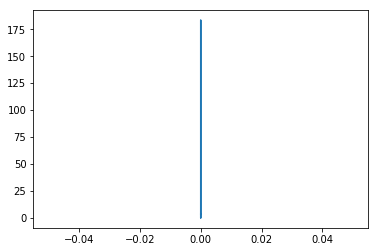

In [104]:
X_enc = encoder.predict(X)
enc_one = X_enc[:,0]
enc_two = X_enc[:,1]
plt.plot(enc_one, enc_two)

In [ ]:
var = {}
var['lartpc'] = 1.0
var['larrout'] = 3.0

const = {}
const['catr'] = 4.0
const['circ'] = 2.0
const['nbv'] = 2.0
const['vosp'] = 0.0
const['prof'] = 1.0
const['plan'] = 1.0
const['surf'] = 1.0
const['env1'] = 0.0

X = pd.read_csv('../Accidents/road_data.csv', index_col=0)

# save the model to disk
#filename = 'trained_model.sav'
#pickle.dump(model, open(filename, 'wb'))

retun_tsne(var, const, X, 10000)